In [1]:
# this code is basically the same as the v1 code, but it's nice and cleaned up!

# I also tested it on 9/26, 9/27, and 9/29, and all those cases work perfectly! I should try to automate this and 
# see if I run into problems with boundary cases (flight data not included in the tc track, espeically for weak tcs)

# also, it would be cool to use the distance from the tc center to find a better rmw value. Basically, find distance when 
# rmw = 1, then divide the current distance by the rmw dist to get an rmw scale... this seems a lot better than just
# defining an arbitrary, constant rmw axis!! especially when circling in the tc eye. Can use a lot more of the data points 
# yay! :)

In [1]:
# import...
import numpy as np
import xarray as xr
import os
import matplotlib.pyplot as plt
from matplotlib import cm
import pandas as pd
import sys

import warnings
import pandas as pd
from scipy.signal import find_peaks

# helpful for making maps with cartopy
import matplotlib.patches as mpatches
import shapely.geometry as sgeom
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from geopy import distance

os.chdir("/Users/etmu9498/research/code/scripts")
import make_plots_new_heights
import make_plots
import tc_metadata
import helper_fns

os.chdir("/Users/etmu9498/research/code/scripts/in-situ-scripts")
import load_in_situ_data

sys.path.append("/Users/etmu9498/research/code/scripts/plotting")
import rmw_inner_outer_stats as extra_stats # confidence interval function resides here!
import fl_vpeaks_algorithms as peak_algs

sys.path.append("/Users/etmu9498/research/code/scripts/obj-data-analysis")
import ch1_statistics # confidence interval function resides here!


In [3]:
# load one new sam dataset for testing

fl_new_path = "/Users/etmu9498/research/data/in-situ-noaa-full/2021/"
os.chdir(fl_new_path)
samname = '20210929H2_sam.nc' # '20210929H2_AC.nc' # change me!
sam_data = xr.open_dataset( samname, decode_times=False)
names = ['sam', 'sam']

# creating the time (decimal) axis
# interval_str holds the start and end times as a string. cut down interval_str to get the start hour, min, sec!
interval_str = sam_data.attrs['TimeInterval']
h = float( interval_str[0:2])
m = float( interval_str[3:5])
s = float( interval_str[6:8])
start_time = h + m / 60 + s / 3600

# create the time array manually
time = np.empty( ( len( sam_data['Time'])))
for timei in range( len( sam_data['Time'])):
    # add to time array
    time[ timei] = start_time + timei / 3600    
sam_data['float_time'] = time

print( 'Time array saved')

Time array saved


In [5]:
###############################
# new code
# load the file holding tc position / track info for each tc
###############################

# find all the unique tc names in the code above
# this helps to automate loading track info! Prevents loading multiple tracks for the same TC
# doesn't really matter in this test case, though

year = '2021'

unique_names = []
for namei in range( len( names)):    
    tcname = names[ namei]
    # check through unique_names list: should we add the new name?
    if len( unique_names) == 0:
        unique_names.append( tcname)
    else:
        present = False
        for i in range( len( unique_names)):
            if tcname == unique_names[ i]:
                present = True
        if not present:
            unique_names.append( tcname)          
# print( unique_names)
  

# load the track data for each unique tc name! Save it in a nice pandas dataframe
# iteratively save them in the list below    
track_data_list = []
track_file_path = "/Users/etmu9498/research/data/track/"
for index in range( len( unique_names)):
    
    tcname = unique_names[ index].lower()
    filename = tcname + year + ".trak"
    
    col_names = ['date', 'time (UTC)', 'lat', 'lat dir', 'lon', 'lon dir']
    track_data = pd.read_fwf( track_file_path + filename, skiprows=3, names = col_names)
    
    # add a new column with time as a decimal
    float_times = []
    for ind in range( np.shape( track_data)[0]):
        str_timei = track_data['time (UTC)'][ ind]
        
        # calculate the decimal time
        h = float( str_timei[0:2])
        m = float( str_timei[3:5]) 
        s = float( str_timei[6:8]) 
    
        float_times.append( h + m / 60 + s / 3600)
    track_data[ 'float_time'] = float_times
    
    # add a new column with the date in the format of new flight level netcdfs
    newdates = []
    for ind in range( np.shape( track_data)[0]):
        old_datei = track_data.date[ ind]
        
        newdates.append( old_datei[6:10] + old_datei[0:2]+old_datei[3:5])
    track_data[ 'date2'] = newdates
    
    track_data_list.append( track_data)

# print( type( track_data))
# print( track_data_list)
track_data = track_data_list[ 0]
track_data

,date,time (UTC),lat,lat dir,lon,lon dir,float_time,date2
0,09/25/2021,22:01:48,13.286,N,48.575,W,22.030000,20210925
1,09/25/2021,22:03:48,13.288,N,48.577,W,22.063333,20210925
2,09/25/2021,22:05:47,13.289,N,48.580,W,22.096389,20210925
3,09/25/2021,22:07:47,13.291,N,48.582,W,22.129722,20210925
4,09/25/2021,22:09:48,13.293,N,48.584,W,22.163333,20210925
...,...,...,...,...,...,...,...,...
4529,10/02/2021,04:28:08,31.752,N,61.145,W,4.468889,20211002
4530,10/02/2021,04:30:09,31.760,N,61.141,W,4.502500,20211002
4531,10/02/2021,04:32:08,31.769,N,61.136,W,4.535556,20211002
4532,10/02/2021,04:34:09,31.777,N,61.131,W,4.569167,20211002


In [6]:
##########################
# goal:
# trim down the float_time field saved in the track data to just the days / times of the p-3 pass!
# not just the day referenced in the flight level data's title, but all dates / times in the flight level data! 
# (ex: part of the next day)
# this prevents errors when finding min time differences- if the date range wasn't trimmed, we might find min time
# differences from incorrect days!
##########################


# find flight level (fl) time limits for the current and sometimes the next day
fl_date = samname[0:8]
fl_firstt = sam_data.float_time[0].values
fl_lastt = sam_data.float_time[-1].values

# cut off all data before the start of the p-3 data
# find the indices for the times from the first day
current_day_inds = np.where( track_data['date2'] == samname[0:8])[0]

# find the closest time to the start time!
# need to do first_day_inds[0] to account for indices before the start of first_day_inds!
first_t_ind = current_day_inds[0]  + np.argmin( np.abs( track_data['float_time'][ current_day_inds].values - fl_firstt ))

newdate = []
# find the closest time to the end time!
# same day CASE
if fl_lastt < 24.0:
    last_t_ind = current_day_inds[0]  + np.argmin( np.abs( track_data['float_time'][ current_day_inds].values - lastt ))

# new case: the float_time variable shifts into the next day
# need to look at arrays for the next day 
else:
    # find the next day indices.
    # done this way rather than + 1 to account for flips like 9/29 -> 9/30, or 9/31 -> 10/1
    # look through dates from current day to the end of the array
    for datei in track_data['date2'][ current_day_inds[0] : ]:      
        # new date case: save it and end the loop!
        if datei != samname[0:8]:
            newdate = datei
            break
            
    # still in the if statement, find all the inds for this next day
    next_day_inds = np.where( track_data['date2'] == newdate)[0]
    
    # do - 24 to account for the 24 hour shift!
    last_t_ind = next_day_inds[0]  + np.argmin( np.abs( track_data['float_time'][ next_day_inds].values - ( fl_lastt - 24) ))
    
# make the final array!
dayind = range( first_t_ind, last_t_ind)

# tests
print('flight level info:')
print('flight level date =    ' + fl_date)
print('flight level start t = ' + str(fl_firstt))
print('flight level end t =   ' + str(fl_lastt))
print('flight level end t-24 = ' + str(fl_lastt - 24.0) + '\n')

print('center fix limits:')
print('start index = ' + str( first_t_ind))
print( 'start date: ' + str( track_data['date2'][ first_t_ind]))
print( 'start t = ' + str( track_data['float_time'][ first_t_ind]))

print( 'end index = ' + str( last_t_ind))
print( 'end date: ' + str( track_data['date2'][ last_t_ind]))
print( 'end t = ' + str( track_data['float_time'][ last_t_ind]))


# print( track_data['lat'][dayind])

flight level info:
flight level date =    20210929
flight level start t = 17.80388888888889
flight level end t =   27.6725
flight level end t-24 = 3.6724999999999994

center fix limits:
start index = 2762
start date: 20210929
start t = 17.798611111111114
end index = 3060
end date: 20210930
end t = 3.6799999999999997


TC track added
P-3 flight path added


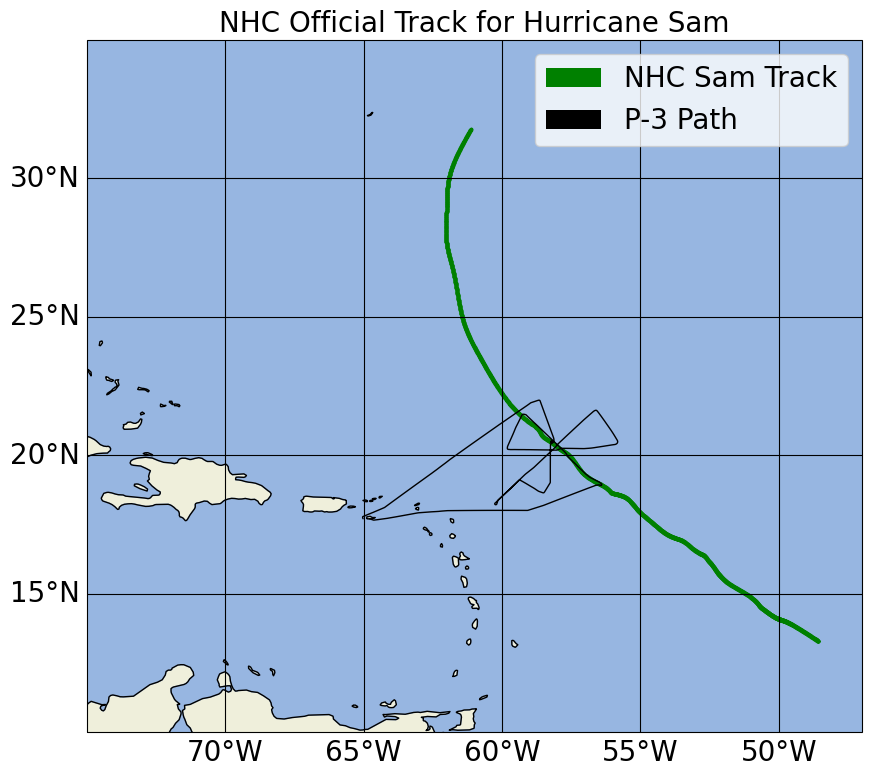

In [7]:
# make a line plot of this tc's track to check out the resolution of its path!

fig = plt.figure( figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
helper_fns.change_font_sizes(20, 20)

# zoomed out   
ax.set_extent([-75, -47, 10, 35], crs=ccrs.PlateCarree())
# zoomed in   
# 9/26
# ax.set_extent([-55, -45, 10, 20], crs=ccrs.PlateCarree()) # zooming in further leads to an odd error :/
# 9/29
# ax.set_extent([-60, -56, 17, 23], crs=ccrs.PlateCarree()) # zooming in further leads to an odd error :/

gl = ax.gridlines( draw_labels=True, color="k")
gl.top_labels = False
gl.right_labels = False

ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)

# plot tc sam's track ( remove [dayind] to plot all track data, not just for the fl interval)
lat = track_data.lat # [dayind]
lon = - track_data.lon # [dayind]   
proj = ccrs.PlateCarree()
img2 = ax.scatter( lon, lat, c = 'g', transform= proj, s= 2.5, marker='o' )

print( 'TC track added')

# plot the flight level data atop tc sam's path
lat2 = sam_data.LATref[::10]
lon2 = sam_data.LONref[::10]    
track2 = sgeom.LineString(zip(lon2, lat2))

ax.add_geometries([track2], ccrs.PlateCarree(),
                  facecolor='none', edgecolor='k')                          

r = [ mpatches.Rectangle((0, 0), 1, 1, facecolor="g"), mpatches.Rectangle((0, 0), 1, 1, facecolor="k")]
labels = ['NHC Sam Track', 'P-3 Path']
ax.legend( r, labels)


print( "P-3 flight path added")

ax.set_title( "NHC Official Track for Hurricane Sam")
ax.set_xlabel( "Longitude (Degrees)")
ax.set_ylabel( "Latitude (Degrees)")
plt.show()


In [7]:
%%time
# for every lat / lon pair, find the tc center fix closest to its time index. Then, find the distance to the tc center!
dists = []

# defining these variables once outside the loop actually saves a ton of time when accessing them
lat = sam_data.LATref.values
lon = sam_data.LONref.values
samtime = sam_data.float_time.values

track_lat = track_data.lat.values [dayind]
track_lon = - track_data.lon.values [dayind] # values are saved as positive from track .txt document
tracktime = track_data.float_time.values [dayind]
trackdate = track_data.date2.values [ dayind]

# first, account for date changes in the time intervals:
fl_orig_date = samname[0:8] # the date when the first pass was completed

for tracktimei in range( len( tracktime)):
    # new date case: increase the time by 24 hours! 
    if trackdate [ tracktimei] != fl_orig_date:
        tracktime[ tracktimei] += 24.0
        
latnans = 0
lonnans = 0

# other methods don't work for speeding up the distance step...
for fl_i in range( len( sam_data.LATref)):
    lati, loni, timei = lat[ fl_i], lon[ fl_i], samtime[ fl_i]
    
    # find the closest center fix time index!
    
    # if the time difference is too large, don't add this case :/
    # helpful for avoiding edge case errors ( a 15 minute window is used??)
    if np.min( np.abs( tracktime - timei )) > .250 :
        dists.append( np.nan)
        pass
    else:
        center_i = np.argmin( np.abs( tracktime - timei ))
    
        #########################
        ## 2/13/23 new code: make sure that the closest center fix time is at least smaller than 15 minutes (?)
        ## and that the date is within the correct bounds!
        #########################

        center_time = tracktime[ center_i]
        center_date = trackdate[ center_i]

        coords_p3 = np.ma.masked_invalid( ( lati, loni))
        coords_center = np.ma.masked_invalid( ( track_lat[center_i], track_lon[center_i]))    
        center_dist_i = distance.geodesic( coords_p3, coords_center).km

        # nan cases- can't find a distance
        if np.isnan( lati):
            latnans += 1
            center_dist_i = np.nan
        if np.isnan( loni):
            lonnans += 1
            center_dist_i = np.nan

        # otherwise, append a valid distance to the dists list 
        dists.append( center_dist_i)
   
    # nice user notices
    if fl_i == 0:
        print( 'number of flight level data points: ' + str( len( sam_data.LATref)))
    if fl_i % 2500 == 0:
        print( 'index = ' + str( fl_i))
        print( 'fl time = ' + str( timei))
        print( 'center time = ' + str( center_time))
        print( 'center date = ' + str( center_date) + '\n')

    
print('number of lat nans: ' + str( latnans))
print('number of lon nans: ' + str( lonnans))


###############################
## 2/14/23 new code: add the newly created distance axis to the xarray dataset
###############################
sam_data['dist'] = dists

print( sam_data[ 'dist'])

number of flight level data points: 33766
index = 0
fl time = 18.145555555555553
center time = 18.156666666666666
center date = 20210927

index = 2500
fl time = 18.839999999999996
center time = 18.842222222222222
center date = 20210927

index = 5000
fl time = 19.534444444444443
center time = 19.541944444444447
center date = 20210927

index = 7500
fl time = 20.228888888888886
center time = 20.23638888888889
center date = 20210927

index = 10000
fl time = 20.923333333333332
center time = 20.93611111111111
center date = 20210927

index = 12500
fl time = 21.617777777777775
center time = 21.603055555555557
center date = 20210927

index = 15000
fl time = 22.31222222222222
center time = 22.315
center date = 20210927

index = 17500
fl time = 23.006666666666664
center time = 23.014722222222222
center date = 20210927

index = 20000
fl time = 23.70111111111111
center time = 23.706944444444442
center date = 20210927

index = 22500
fl time = 24.395555555555553
center time = 24.406666666666666
cente

33766
33766


(0.0, 500.0)

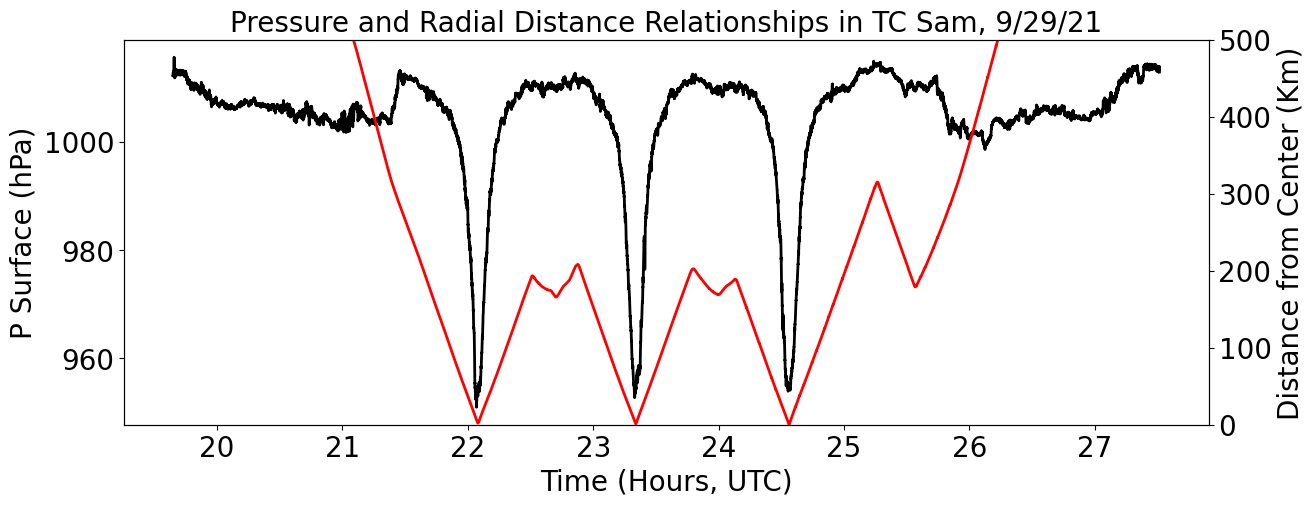

In [9]:
# make sure arrays are the same length for plotting
print( len( dists))
print( len( samtime))

# make a simple plot showing pressure drops overlapping with distance from the tc center... looks good!
lw = 2
fig = plt.figure( figsize=(14, 5))
helper_fns.change_font_sizes(20, 20)

ax = plt.gca()
ax.plot( samtime, sam_data['PSURF.d'], c='k', linewidth=lw)
ax.set_ylabel( "P Surface (hPa)")
ax.set_title( "Pressure and Radial Distance Relationships in TC Sam, 9/29/21")
ax.set_xlabel("Time (Hours, UTC)")

ax2 = ax.twinx()
ax2.plot( samtime, sam_data['dist'], c='r', linewidth=lw)
ax2.set_ylabel( "Distance from Center (Km)")

ax2.set_ylim( [0, 500])

# ax2.set_ylim( [0, 50])


In [10]:
#####################################
## 2/13/23 new goal: create an updated rmw axis using the new, precise distance axis!
#####################################

# step 1: find vpeaks using the typical method

# input vars used later
max_v_requirement=40
window=10
timelim = 60

# restating important metadata defined above
fl_path = "/Users/etmu9498/research/data/in-situ-noaa-full/2021/"
os.chdir(fl_new_path)
samname = samname
sam_data = xr.open_dataset( samname, decode_times=False)

fl_data = sam_data

# do this for just the sam case listed above
# load data
title = "All Flight Level Data for Flight " + samname

# creating the axis
# this string holds the start and end times. cut down the interval dataset to get the hours, mins, secs!
interval_str = fl_data.attrs['TimeInterval']
h = float( interval_str[0:2])
m = float( interval_str[3:5])
s = float( interval_str[6:8])
start_time = h + m / 60 + s / 3600

# create the time array manually
# if this is too slow, try using pandas? see stack overflow link below...
# https://stackoverflow.com/questions/55648630/how-to-decode-the-time-variable-while-using-xarray-to-load-a-netcdf-file
time = np.empty( ( len( fl_data['Time'])))
for timei in range( len( fl_data['Time'])):
    # add to time array
    time[ timei] = start_time + timei / 3600

spd_avg = pd.Series( fl_data['WS.d']).rolling(window=window, min_periods=1, center=True).mean()

vpeaks, pmins, time_lims = peak_algs.find_peaks_pmin_time_limit( fl_data['PSURF.d'], spd_avg, time, window, timelim=timelim)

print( pmins)
print( vpeaks)

[14128 18669 23074]
[13879, 14432, 18429, 18949, 22883, 23382]


In [11]:
# step 2: find distances at each wind speed peak. Use these distances to define a new rmw axis. 
# go through a couple if statements to determine which rmw1 value to use as the rmw limit

rmw0_vals = []
for peak in pmins:
    rmw0_vals.append( dists[ peak])
print( rmw0_vals)

rmw1_vals = []
for peak in vpeaks:
    rmw1_vals.append( dists[ peak])
print( rmw1_vals)


#######################
## testing using distance mins ( also velocity mins), rather than pressure mins, to find the center?!
## these methods might be better, but it kinda sounds too complicated for right now lol
#######################
distmins = find_peaks( x= - np.array( dists), prominence = 25.0)[0]
print( distmins)

vmins = find_peaks( x= - spd_avg, prominence = 15.0)[0]
print( vmins)

[6.089726828792399, 4.059436928166579, 3.7344180437555328]
[36.51595920906228, 32.42335040545732, 32.812640158683934, 30.873682253269774, 26.508809586294966, 35.191379979954476]
[14171 16412 18700 23103 26725]
[14183 17009 18697 20214 23105]


In [12]:
# divide up the distance axis into distinct RMW regions
# do this for every peak

rmwlist = []
rainbandlist = []
for vpeaki, vpeak in enumerate( vpeaks):

    print( 'vpeak index = ' + str( vpeaki))
    
    # figure out the distances to the peak winds and current pressure center
    rmw1 = rmw1_vals[ vpeaki]
    # use // to get rid of remainder
    pressurei = vpeaki // 2
    rmw0 = rmw0_vals[ pressurei]
    
    # first value case: count everything before the first wind speed to the center
    if vpeaki == 0:
        # divide by rmw1 so that the distance at the peak winds = 1!
        rmwlist += (np.array( dists [ 0 : pmins[ pressurei] ]) / rmw1).tolist() 
        
        continue
        
    # last value case: count everything from the last center to the end of the dataset
    elif vpeaki == len( vpeaks) - 1:
        rmwlist += (np.array( dists [ pmins[ pressurei] : len( dists)]) / rmw1).tolist() 
        
        continue
        
    # middle cases: things are more complicated lol
    
    # odd cases: the center has already been passed
    elif vpeaki % 2 == 1:        
        # find the index in the rainbands
        # should be halfway between the two closest pressure centers
        # first pressure center + ( difference / 2)
        rainband_ind = int( pmins[ pressurei] + ( ( pmins[ pressurei + 1] - pmins[ pressurei]) / 2) )
        
        rainbandlist.append( rainband_ind)
        print( 'rainband index = ' + str( rainband_ind))
        
        # go from the previous pressure center to a defined point in the outer rainbands
        rmwlist += ( np.array( dists [ pmins[ pressurei] : rainband_ind]) / rmw1).tolist() 
        
    # even cases: the center is being approached
    elif vpeaki % 2 == 0:
        # find the index in the rainbands
        rainband_ind = int( pmins[ pressurei - 1] + ( ( pmins[ pressurei ] - pmins[ pressurei - 1]) / 2) )

        rainbandlist.append( rainband_ind)
        print( 'rainband index = ' + str( rainband_ind))

        # go from the past halfway mark out in the rainbands to the next pressure center
        rmwlist += ( np.array( dists [ rainband_ind : pmins[ pressurei] ]) / rmw1).tolist() 
        
        
    else:
        print( "Error: idk how this happened lol")
        
sam_data['rmw'] = rmwlist
sam_data['dist'] = dists
sam_data['float_time'] = time

        
# testing
print( 'length of dist array = ' + str( len( rmwlist)))
print( 'length of rmw array =  ' + str( len( rmwlist)))
# print( rmwlist)

vpeak index = 0
vpeak index = 1
rainband index = 16398
vpeak index = 2
rainband index = 16398
vpeak index = 3
rainband index = 20871
vpeak index = 4
rainband index = 20871
vpeak index = 5
length of dist array = 33766
length of rmw array =  33766


In [13]:
print( sam_data[ 'rmw' ][ 10000 : 10500])
print( sam_data[ 'dist' ][ 10000 : 10500])

<xarray.DataArray 'rmw' (rmw: 500)>
array([16.379276, 16.374739, 16.370203, ..., 14.095451, 14.091543, 14.087614])
Coordinates:
  * rmw      (rmw) float64 16.38 16.37 16.37 16.37 ... 14.1 14.1 14.09 14.09
<xarray.DataArray 'dist' (dist: 500)>
array([598.104983, 597.939313, 597.773664, ..., 514.708899, 514.566221,
       514.422755])
Coordinates:
  * dist     (dist) float64 598.1 597.9 597.8 597.6 ... 514.9 514.7 514.6 514.4


(0.0, 15.0)

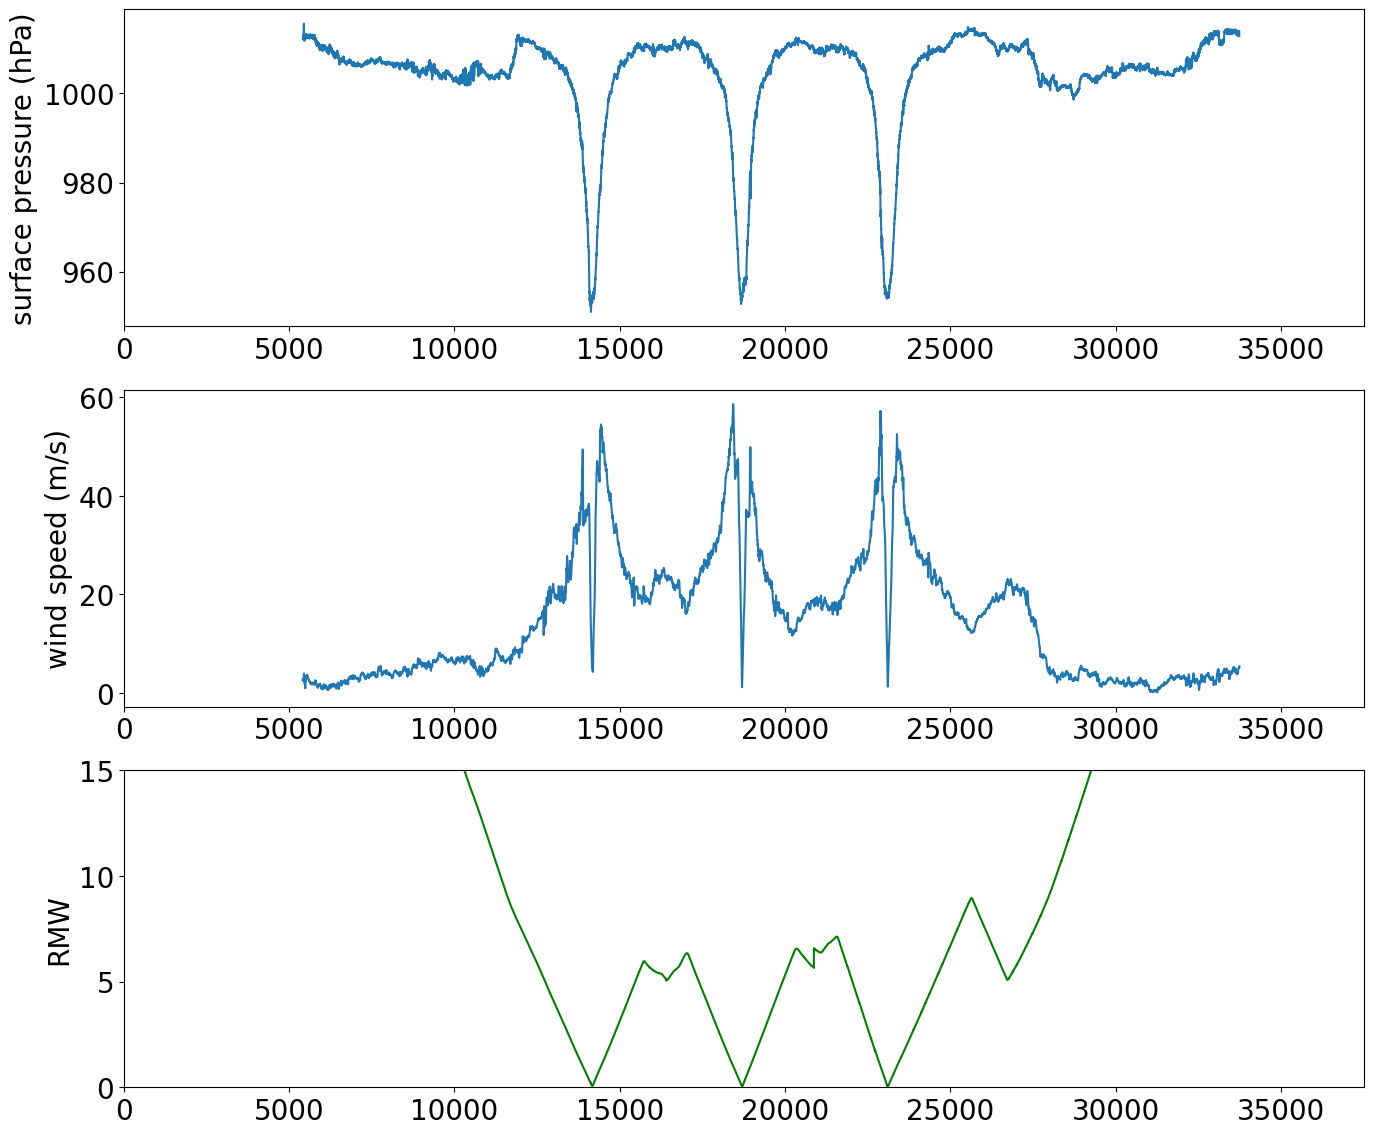

In [16]:
# quick test plot

# print( len( fl_data['Time']))

plt.figure(figsize=(16, 14))
plt.subplot(311)
plt.plot( fl_data['Time'], fl_data['PSURF.d'])
plt.ylabel( 'surface pressure (hPa)')

plt.xlim( [0, 37500])

plt.subplot(312)
plt.plot( fl_data['Time'], spd_avg)
plt.ylabel( 'wind speed (m/s)')


plt.xlim( [0, 37500])

#for i in range( len( vpeaks)):
#    plt.axvline( x= vpeaks[ i], c='r')
    
plt.subplot( 313)
plt.plot( fl_data['Time'], rmwlist, c='g')
plt.ylabel( 'RMW')

plt.xlim( [0, 37500])
plt.ylim( [0, 15])

# plot the rainband indices to see if they're in a good spot
#for ind in rainbandlist:
#    plt.axvline( x=ind, c='k')
    
#plt.axvline( x=-5000, c='k', label='RMW Rainband Turning Point Index')
#plt.legend()

In [54]:
var_names = [ 'dist', 'rmw', 'time', 'wind_speed', 'w', 'Rain Rate', 'Theta E', 'Mixing Ratio', 'temp']  # change me!
binwidth = .1 # for testing with larger RMW scale
bins = np.arange(0, 10, step=binwidth) # 20 is also being used for testing: nothing interesting beyond that

print( 'number of operations without array finder:')
print( len( var_names) * len( sam_data['rmw'] ) * ( len( bins) - 1))

print( 'number of operations with array finder:')
print( len( var_names) * len( sam_data['rmw'] ) )

number of operations without array finder:
30085506
number of operations with array finder:
303894


In [55]:
%%time

#####################################
## the code above seems to work! at least with a couple simple cases
## next step: repeat stats analysis conducted using a standard rmw axis, but for all rmw values now!! 
## this is super cool, stats can be calculated for regions outside the eyewall too :) :) :) :) 
##
## code below taken from fl_mean_plots_error.py
## this code might possibly work, but it takes wayyyy too long with the additional data points and bin widths :/
#####################################

# input variables
input_vars = [ 'dist', 'rmw', 'float_time', 'WS.d', 'UWZ.d', 'SfmrRainRate.1', 'THETAE.d', 'MR.d', 'TA.d'] # change me!
var_names = [ 'dist', 'rmw', 'time', 'wind_speed', 'w', 'Rain Rate', 'Theta E', 'Mixing Ratio', 'temp']  # change me!


######################
## bin rmw data!
######################

# initialize the dataframe to save binned data
df_binned = pd.DataFrame( )


# pick a bin width for rmw values, sort velocities into those bins, and
# calculate important quantities like the mean, standard deviation, and confidence levels!
binwidth = .1 # for testing with larger RMW scale

# make an array representing the bins!
bins = np.arange(0, 10, step=binwidth) # 20 is also being used for testing: nothing interesting beyond that


# create an array of midpoints (right between two given binwidths)
# will be 1 val shorter than bins array
# used for plotting later
midpoints = []
for i in range( len( bins) - 1):
    midpoints.append( (bins[ i] + bins[ i+1]) / 2)

# the same as the list above but saved in array form, helpful during loop1
midpointarray = np.array( midpoints)

#print( bins)
#print( midpoints)
#print( type( midpointarray))

# add midpoints and bins to the data array
df_binned[ 'bins'] = bins[ 0: len( bins)-1] # drop last value for correct array size
df_binned[ 'midpoints'] = midpoints

nancount = 0


########################
## actually do the averaging within each bin!!
########################

# do this for every variable
for var_i in range( len( input_vars)):

    
    input_field = input_vars[ var_i]
    print( 'Adding Variable: ' + input_field)

    
    # this variable holds the sorted contents for each input field!
    # it starts as an empty list of lists
    sorted_var = []
    for i in range( len( bins) - 1):
        sorted_var.append( [])

    data_field = sam_data[ input_field ]

    
    # sort through every rmw axis value for a given eye pass: check if it's within the bin!
    for rmw_i in range( len( sam_data['rmw'] )):

        # locally define the current value for convenience :)
        rmw_val = sam_data['rmw'][rmw_i]


        if np.isnan( rmw_val):   
            nancount += 1
        else:
            # print( midpointarray)
            # print( rmw_val.values)

            # new method: use array subtraction to find the closest midpoint to the given rmw_i
            closebini = np.argmin( np.abs( midpointarray - rmw_val.values ))
            sorted_var[ closebini].append( data_field[rmw_i].values )

        if rmw_i % 10000 == 0:
            print( "Index " + str( rmw_i))
            
        # old slow method
        '''
        # sort through the bins
        # -1 to account for two bins being chosen in the beginning
        for bin_i in range( len( bins) - 1):

            # check if the current rmw value is within this bin!
            bin_val_i = bins[ bin_i]
            bin_val_next = bins[ bin_i + 1]

            ##############
            # important!
            # maybe round to the 2nd or 3rd decimal place for this step?

            if ( rmw_val >= bin_val_i and rmw_val < bin_val_next) or (- rmw_val >= bin_val_i and - rmw_val < bin_val_next):

                # append the values to the sorted list
                # rmw values are already floats, other vars need to use .values to switch from xarray to floats!
                if input_field != 'rmw':
                    sorted_var[ bin_i].append( data_field[pass_i][rmw_i].values )
                else:
                    sorted_var[ bin_i].append( data_field[pass_i][rmw_i] )
        '''

    # after going through every pass for this variable, add the results to the dataframe!
    df_binned[ var_names[ var_i ] ] = sorted_var

Adding Variable: dist
Index 0
Index 1000
Index 2000
Index 3000
Index 4000
Index 5000
Index 6000
Index 7000
Index 8000
Index 9000
Index 10000
Index 11000
Index 12000
Index 13000
Index 14000
Index 15000
Index 16000
Index 17000
Index 18000
Index 19000
Index 20000
Index 21000
Index 22000
Index 23000
Index 24000
Index 25000
Index 26000
Index 27000
Index 28000
Index 29000
Index 30000
Index 31000
Index 32000
Index 33000
Adding Variable: rmw
Index 0
Index 1000
Index 2000
Index 3000
Index 4000
Index 5000
Index 6000
Index 7000
Index 8000
Index 9000
Index 10000
Index 11000
Index 12000
Index 13000
Index 14000
Index 15000
Index 16000
Index 17000
Index 18000
Index 19000
Index 20000
Index 21000
Index 22000
Index 23000
Index 24000
Index 25000
Index 26000
Index 27000
Index 28000
Index 29000
Index 30000
Index 31000
Index 32000
Index 33000
Adding Variable: float_time
Index 0
Index 1000
Index 2000
Index 3000
Index 4000
Index 5000
Index 6000
Index 7000
Index 8000
Index 9000
Index 10000
Index 11000
Index 12

In [30]:
print( df_binned)

     bins  midpoints                                               dist  \
0     0.0       0.05  [3.3272143031897525, 3.205072726990082, 3.0831...   
1     0.1       0.15  [6.884686526245809, 6.754737328679203, 6.62485...   
2     0.2       0.25  [10.26987339880194, 10.140025742603319, 10.010...   
3     0.3       0.35  [13.704259963362714, 13.57842517905972, 13.452...   
4     0.4       0.45  [17.182146244130884, 17.059145577549273, 16.93...   
..    ...        ...                                                ...   
194  19.4      19.45  [672.3307151113981, 672.1906052885753, 672.050...   
195  19.5      19.55  [675.8165123751904, 675.6775028581602, 675.538...   
196  19.6      19.65  [679.2826432654952, 679.1444374585827, 679.005...   
197  19.7      19.75  [682.7280361163791, 682.5902583724238, 682.452...   
198  19.8      19.85  [806.5317842361529, 806.5284490845662, 806.525...   

                                                   rmw  \
0    [0.09815528984200625, 0.094552022747

Confidence intervals found for dist
Confidence intervals found for rmw
Confidence intervals found for time
Confidence intervals found for wind_speed
Confidence intervals found for w
Confidence intervals found for Rain Rate
Confidence intervals found for Theta E
Confidence intervals found for Mixing Ratio
Confidence intervals found for temp


Text(0.5, 0, 'Radius of Maximum Wind')

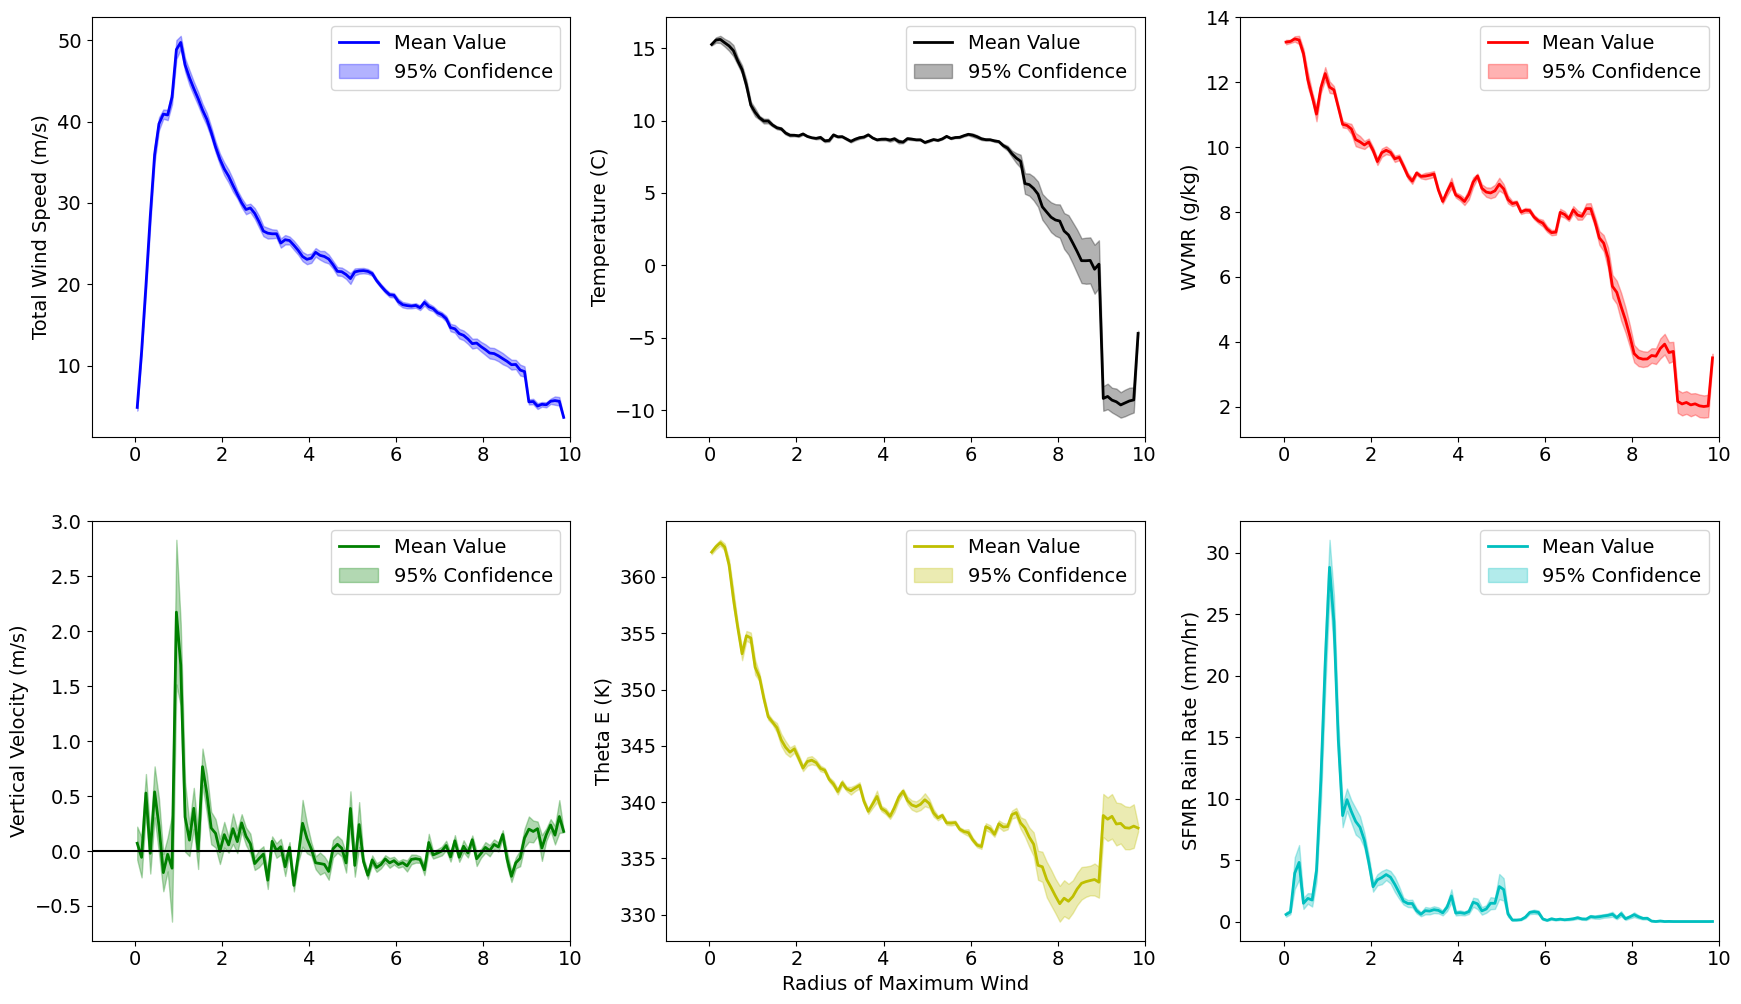

In [56]:
confidence = .95

for var_i in range( len( var_names)):
    var_mean, var_lowc, var_highc = [], [], []

    field = df_binned[ var_names[ var_i] ]

    # do this for every bin for that variable
    for i in range( len( df_binned[ 'midpoints'] )):

        # np.ma.masked_array( field[ i], np.isnan( field[ i]))
        mean, lowc, highc = ch1_statistics.t_test_intervals(
                    field[i], confidence=confidence)
        var_mean.append(  mean)
        var_lowc.append(  lowc)
        var_highc.append(  highc)

    # after going through every pass for this variable, add the results to the dataframe!
    df_binned[ var_names[ var_i] + "_mean"] = var_mean
    df_binned[ var_names[ var_i] + "_highc"] = var_highc
    df_binned[ var_names[ var_i] + "_lowc"] = var_lowc

    print( "Confidence intervals found for " + var_names[ var_i])


###############################
## make figure
###############################
# make figure
plt.figure( figsize=(21, 12))
lw = 2.
helper_fns.change_font_sizes(14, 14)

# make plots of total wind speed and vertical vels along new rmw axes!
plt.subplot(231)

subplots = [ 231, 232, 233, 234, 235, 236]
ylabels = [ "Total Wind Speed (m/s)", "Temperature (C)", "WVMR (g/kg)", "Vertical Velocity (m/s)", "Theta E (K)",
          "SFMR Rain Rate (mm/hr)"]
colors = ['b', 'k', 'r', 'g', 'y', 'c']

# use the var_names list defined way earlier for plotting!
new_var_names = ['wind_speed', 'temp', 'Mixing Ratio', 'w', 'Theta E', 'Rain Rate' ]

for i in range( len( subplots)):

    plt.subplot( subplots[ i])
    plt.ylabel(ylabels[ i])
    plt.xlim( [-1, 10])
    plt.plot( df_binned[ 'midpoints'], df_binned[ new_var_names[ i] + '_mean'], c=colors[i], linewidth=lw, label="Mean Value")

    ax = plt.gca()
    ax.fill_between( df_binned[ 'midpoints'], df_binned[ new_var_names[ i] + '_lowc'], df_binned[ new_var_names[ i] + '_highc'],
                    color=colors[i], alpha=0.3, label=str( int(confidence*100)) + "% Confidence")
    ax.legend()

plt.subplot(234)
plt.axhline(y=0, linewidth = 1.5, c='k')

plt.subplot(235)
plt.xlabel("Radius of Maximum Wind")
